In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report)

In [5]:
data=pd.read_csv("Dataset.csv")
data

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [6]:
data.columns = [c.strip().lower().replace('-', '_').replace(' ', '_') for c in data.columns]

In [7]:
label_col = None
# quick heuristic: small-unique-values columns with yes/no/0/1
for c in data.columns:
    vals = data[c].dropna().unique()
    if len(vals) <= 5:
        strs = [str(v).lower() for v in vals]
        if any(v in ['yes','no','y','n','true','false','0','1','no-show','noshow'] for v in strs):
            label_col = c
            break
# fallback names
for cand in ['no_show','noshow','no-show','no_show_flag','no_show?']:
    if label_col is None and cand in data.columns:
        label_col = cand

In [8]:
if label_col:
    print("Detected label column:", label_col)
    data['no_show'] = data[label_col].astype(str).str.strip().str.lower()
    data['no_show'] = data['no_show'].replace({
        'no':'0','n':'0','false':'0','0':'0',
        'yes':'1','y':'1','true':'1','1':'1',
        'no-show':'1','noshow':'1'
    })
    data['no_show'] = pd.to_numeric(data['no_show'], errors='coerce').fillna(0).astype(int)
else:
    print("No label found; creating placeholder 'no_show' = 0")
    data['no_show'] = 0


Detected label column: scholarship


In [9]:
for c in data.columns:
    if 'date' in c or 'day' in c:
        try:
            data[c] = pd.to_datetime(data[c], errors='coerce')
            print("Converted to datetime:", c)
        except Exception:
            pass

Converted to datetime: scheduledday
Converted to datetime: appointmentday


In [10]:
if 'scheduled_day' in data.columns and 'appointment_day' in df.columns:
    data['wait_days'] = (data['appointment_day'].dt.normalize() - data['scheduled_day'].dt.normalize()).dt.days
    data.loc[data['wait_days'] < 0, 'wait_days'] = 0
else:
    # attempt naive fallback
    dt_cols = [c for c in data.columns if pd.api.types.is_datetime64_any_dtype(data[c])]
    if len(dt_cols) >= 2:
        data['wait_days'] = (data[dt_cols[1]].dt.normalize() - data[dt_cols[0]].dt.normalize()).dt.days.abs()
    else:
        data['wait_days'] = np.nan

In [11]:
if 'age' in data.columns:
    data['age'] = pd.to_numeric(data['age'], errors='coerce')
    data.loc[data['age'] < 0, 'age'] = np.nan
    data['age'] = data['age'].fillna(data['age'].median()).astype(int)


In [12]:
if 'sms_received' in data.columns:
    data['sms_flag'] = (data['sms_received'] > 0).astype(int)
if 'gender' in data.columns:
    data['gender'] = data['gender'].astype(str).str.strip().str.upper().replace({'FEMALE':'F','MALE':'M'})

In [13]:
if 'appointment_day' in data.columns and pd.api.types.is_datetime64_any_dtype(data['appointment_day']):
    data['appointment_dow'] = data['appointment_day'].dt.day_name()
    data['appointment_month'] = data['appointment_day'].dt.month

No-show rate: 0.09826558216544373


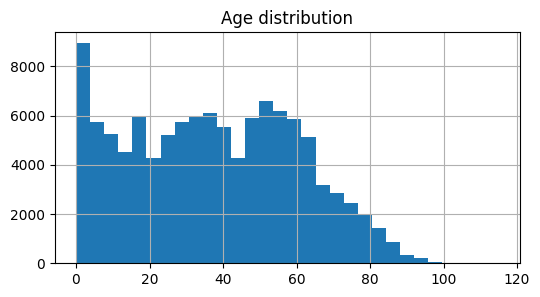

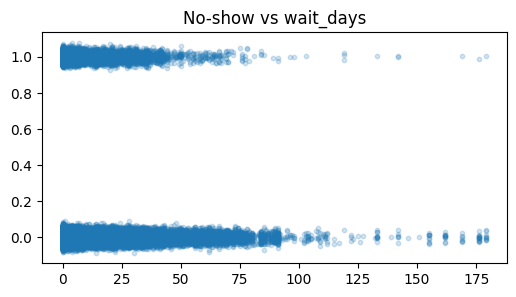

In [14]:
print("No-show rate:", data['no_show'].mean())
if 'age' in data.columns:
    plt.figure(figsize=(6,3)); data['age'].hist(bins=30); plt.title('Age distribution'); plt.show()
if 'wait_days' in data.columns:
    plt.figure(figsize=(6,3)); plt.scatter(data['wait_days'], data['no_show'] + np.random.normal(0,0.02,len(data)), s=10, alpha=0.2); plt.title('No-show vs wait_days'); plt.show()

In [16]:
candidates = []
for c in ['age','wait_days','sms_received','sms_flag','gender','neighbourhood','appointment_dow']:
    if c in data.columns:
        candidates.append(c)
print("Selected features:", candidates)

X = data[candidates].copy()
y = data['no_show'].copy()

Selected features: ['age', 'wait_days', 'sms_received', 'sms_flag', 'gender', 'neighbourhood']


In [17]:
candidates = []
for c in ['age','wait_days','sms_received','sms_flag','gender','neighbourhood','appointment_dow']:
    if c in data.columns:
        candidates.append(c)
print("Selected features:", candidates)

X = data[candidates].copy()
y = data['no_show'].copy()

Selected features: ['age', 'wait_days', 'sms_received', 'sms_flag', 'gender', 'neighbourhood']


In [19]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
pipe_lr = Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
pipe_rf = Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))])

In [23]:
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'wait_days',
                                                   'sms_received',
                                                   'sms_flag']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'neighbourhood'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [24]:
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

In [26]:
def eval_model(y_true, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    except:
        print("ROC AUC: not computable")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, zero_division=0))


In [27]:
print("\nLogistic Regression:")
eval_model(y_test, y_pred_lr, y_proba_lr)
print("\nRandom Forest:")
eval_model(y_test, y_pred_rf, y_proba_rf)


Logistic Regression:
Accuracy: 0.6427214330950873
Precision: 0.1875136433093211
Recall: 0.7909760589318601
F1: 0.30315863772719254
ROC AUC: 0.7562544333686063
Confusion matrix:
 [[12490  7444]
 [  454  1718]]
              precision    recall  f1-score   support

           0       0.96      0.63      0.76     19934
           1       0.19      0.79      0.30      2172

    accuracy                           0.64     22106
   macro avg       0.58      0.71      0.53     22106
weighted avg       0.89      0.64      0.71     22106


Random Forest:
Accuracy: 0.8684972405681716
Precision: 0.3531761885737115
Recall: 0.40699815837937386
F1: 0.3781818181818182
ROC AUC: 0.8202136687348176
Confusion matrix:
 [[18315  1619]
 [ 1288   884]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     19934
           1       0.35      0.41      0.38      2172

    accuracy                           0.87     22106
   macro avg       0.64      0.66      0.

In [28]:
try:
    ohe = pipe_rf.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(categorical_features))
except Exception:
    cat_names = []
feature_names = numeric_features + cat_names
importances = pipe_rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
print(feat_imp)

age                                  0.442566
wait_days                            0.196171
gender_F                             0.025968
gender_M                             0.023047
neighbourhood_JARDIM CAMBURI         0.019971
neighbourhood_JARDIM DA PENHA        0.019644
neighbourhood_MARIA ORTIZ            0.016900
neighbourhood_ILHA DO PRÍNCIPE       0.009373
neighbourhood_JESUS DE NAZARETH      0.008846
neighbourhood_CARATOÍRA              0.007622
neighbourhood_ILHA DE SANTA MARIA    0.007404
sms_flag                             0.007378
sms_received                         0.007365
neighbourhood_SÃO BENEDITO           0.006858
neighbourhood_CENTRO                 0.005870
neighbourhood_RESISTÊNCIA            0.005542
neighbourhood_SANTA MARTHA           0.005262
neighbourhood_SANTO ANDRÉ            0.005245
neighbourhood_TABUAZEIRO             0.005178
neighbourhood_PRAIA DO CANTO         0.005078
dtype: float64


In [30]:
out = 'Dataset_cleaned.csv'
data.to_csv(out, index=False)
print("Saved cleaned dataset to:", os.path.abspath(out))

Saved cleaned dataset to: c:\Users\Gowtham\OneDrive\Desktop\El\Dataset_cleaned.csv
